# **GIS × Python Tutorial Session10 ~ DSMの作成とDCHMの作成 ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。

<br><br><br>



## **はじめに**
---
前回の記事では DTM の後処理を行い、滑らかな DTM を作成しました。今回は DSM の作成と DCHM の作成を行います。

<br><br>

## **今回使用するデータ**
---
今回の記事では、オープンナガサキからダウンロードした点群データと前回の記事で作成した DTM を使用します。作成には `PDAL` と `rasterio` を使用しますので、このチュートリアルを初めて見た方は Session6 から読み進めて頂くとわかりやすいと思います。その他に国土地理院で公開されている基盤地図情報ダウンロードサイトから入手した5mメッシュの地形情報も使用します。

https://zenn.dev/daidai_daitai/articles/4071f5aa17cd4b

conda 環境の設定ファイルや、この記事の作成に使用した Notebook は GitHub で公開しています。

https://github.com/shingo405nagano/WriteZenn

国土地理院 基盤地図情報ダウンロードサイト

https://fgd.gsi.go.jp/download/menu.php

<br><br>



## **目次**
---
   
   1. DSM の作成

      1-1. DSM、DTM、DCHMとは

      1-2. 点群データの読み込みと DSM の作成

      1-3. DSM の可視化

   2. DCHM の作成

      2-1. DTMとDSMの差分をDCHMとする方法

      2-2. 点群データからDTMの値を差し引きDCHMを作成する方法

      2-3. 地上分解能の違うRasterでDCHMを計算する方法

<br>

In [25]:
import json
from IPython.display import Image
from pprint import pprint

import japanize_matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pdal
import pyproj
import rasterio
import rasterio.mask
import rasterio.enums
import seaborn as sns
import shapely
from shapely.plotting import plot_polygon
japanize_matplotlib.japanize()

IN_FILE_LAS = r'../datasets/01ID7913_proj.las'
IN_FILE_DTM = r'../datasets/01ID7913_DTM_R05_SMOOTH.tif'
OUT_FILE_DSM = r'../datasets/01ID7913_DSM_R05.tif'
OUT_FILE_DCHM = r'../datasets/01ID7913_DCHM_R05.tif'
OUT_FILE_DCHM_R2 = r'../datasets/01ID7913_DCHM_R02.tif'
IN_FILE_PUB_DTM = r'../datasets/5029_03_DEM5A.tiff'

IN_EPSG = 'EPSG:6669'
proj_crs = pyproj.CRS(IN_EPSG)
IN_SRS = proj_crs.to_wkt(pretty=True)

<br>

## **1. DSM の作成**
---



<br>

### **1-1. DSM、DTM、DCHMとは**

 - **DTM**（Digital Terrain Model：数値地形モデル）
    ... DTM は地形の高さを表します。DEMと呼ばれる場合もあります。

 - **DSM**（Digital Surface Model：数値表層モデル）
    ... DSM は地形の高さと建物や樹木などの地物を含む高さを表します。

 - **DCHM**（Digital Canopy Height Model：数値樹冠高モデル）
    ... DCHM は純粋な地物の高さを表します。



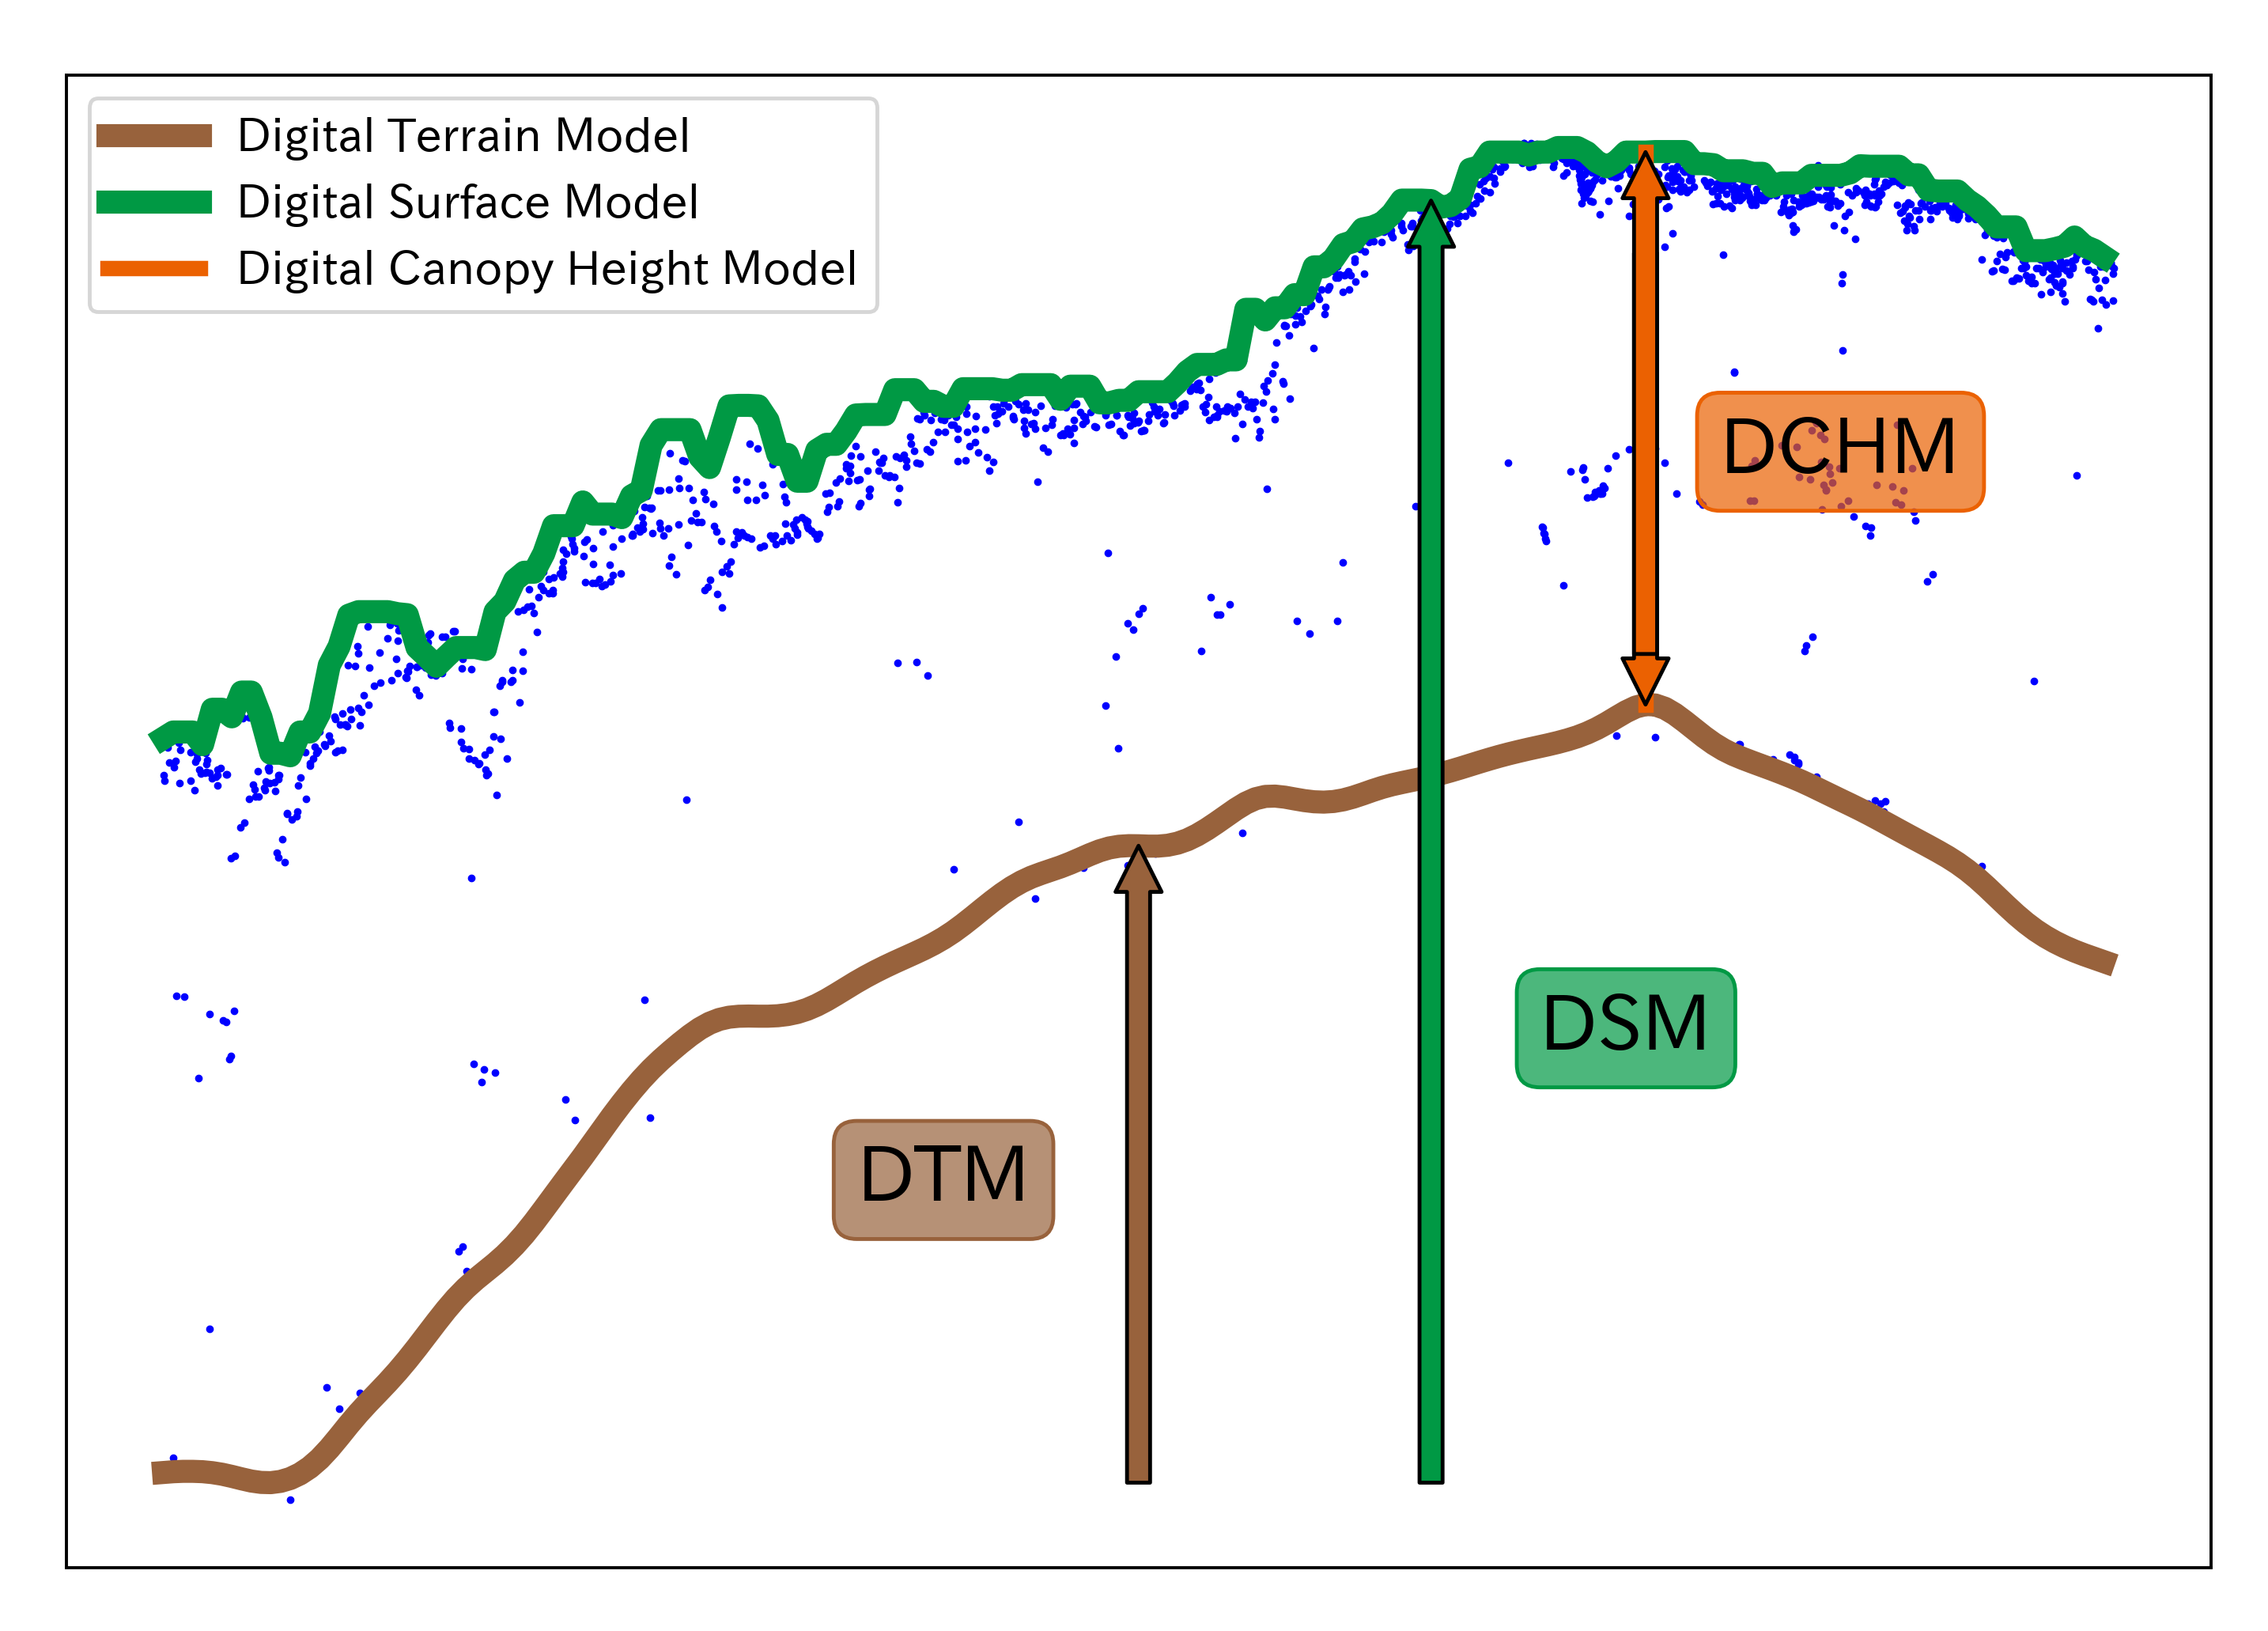

In [2]:
Image(r'../images/session10/raster_imgs.png',  width=800)

<br>

### **1-1. 点群データの読み込みとDSMの作成**
DSM の作成は非常に簡単です。以前の記事で DTM の出力を行った時と同じく PDAL を使用して点群データをグリッドごとに抽出し、該当グリッド内の最も高い測点の高さを記録するだけです。

DTM を作成する場合は 'output_type' を 最小値に指定しましたが、今回は最大値に指定します。

In [3]:
workflow = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': IN_FILE_LAS
        },
        {
            'type': 'writers.gdal',
            'filename': OUT_FILE_DSM,
            'default_srs': IN_SRS,
            'resolution': 0.5,
            'radius': 1.0,
            'window_size': 4,
            'nodata': -9999,
            'output_type': 'max',
            'gdaldriver': 'GTiff'
        }
    ]
}

pipeline = pdal.Pipeline(json.dumps(workflow))
pipeline.execute()

6684581

<br>

### **1-3. DSMの可視化**
単純に可視化しただけでは差が分かりづらかったので、可視化範囲を絞り込んで等高線を追加しています。

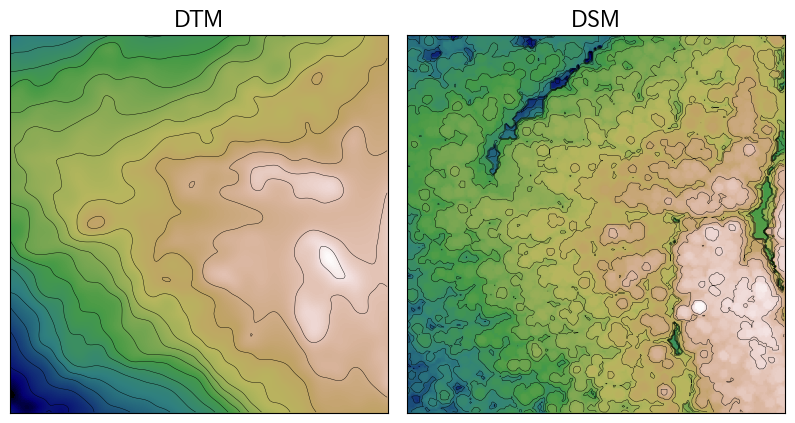

In [7]:
# Rasterの読み込み
dtm_dst = rasterio.open(IN_FILE_DTM, mode='r')

dsm_dst = rasterio.open(OUT_FILE_DSM, mode='r')

# 可視化範囲の設定
def crop_raster(dst, scope):
    return rasterio.mask.mask(dst, shapes=[scope], crop=True)[0][0]


scope = shapely.box(-3800, 37700, -3700, 37800)
dtm = crop_raster(dtm_dst, scope)
dsm = crop_raster(dsm_dst, scope)

# 可視化
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
for _ax, title, img in zip(ax, ['DTM', 'DSM'], [dtm, dsm]):
    level = np.arange(img.min(), img.max(), 2)
    _ax.imshow(img, cmap='gist_earth')
    _ax.contour(img, levels=level, linewidths=0.3, colors='black')
    _ax.axes.yaxis.set_visible(False)
    _ax.axes.xaxis.set_visible(False)
    _ax.set_title(title, fontsize=16)

plt.subplots_adjust(wspace=0.05)
# plt.savefig(r'../images/session10/DTM_AND_DSM.png', dpi=350)
plt.show()

<br>

## **2. DCHMの作成**
---
DCHM の計算は簡単です。DSMを出力していて、地上分解能と範囲が同じであるならば、rasterio で DTM と DSM の両方を読み込み、配列として取得し差分を求めるだけです。

しかし場合によっては地上分解能が違ったり、範囲が微妙に違う場合があります。ここではまず DTM と DSM の差分を求める方法を紹介した後に、DTM と点群データから求める方法、地上分解能の違う2つのRasterの差分を求める方法の 3種類を種類を紹介します。

<br>

### **2-1. DTMとDSMの差分をDCHMとする方法**

説明するまでもなく、単純に DTM の配列と DSM の配列の差分を求めるだけです。これは地上分解能と範囲が同じだという前提が重要になります。どちらか一方でも崩れれば使えない方法になります。

In [9]:
def check_rasters(dst1, dst2):
    checked = {
        'width': False,
        'height': False,
        'transform': False
    }
    for key in checked.keys():
        if dst1.meta[key] == dst2.meta[key]:
            checked[key] = True
    return checked


check_rasters(dsm_dst, dtm_dst)

{'width': True, 'height': True, 'transform': True}

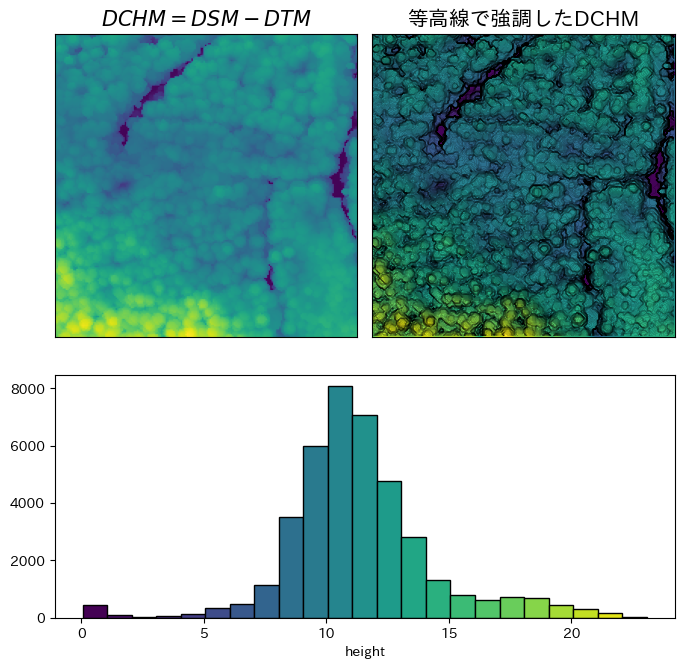

In [10]:
# DCHMの計算
dchm_1 = dsm - dtm

fig = plt.figure(figsize=(8, 8))
shape = (5, 2)
ax1 = plt.subplot2grid(shape=shape, loc=(0, 0), rowspan=3, colspan=1)
ax1.imshow(dchm_1, cmap='viridis')

ax2 = plt.subplot2grid(shape=shape, loc=(0, 1), rowspan=3, colspan=1)
ax2.imshow(dchm_1, cmap='viridis');
level = np.arange(dchm_1.min(), dchm_1.max(), 0.1)
ax2.contour(dchm_1, levels=level, linewidths=0.1, colors='black')

ax3 = plt.subplot2grid(shape=shape, loc=(3, 0), rowspan=2, colspan=2)
bins = np.arange(dchm_1.min(), dchm_1.max(), 1)
_, _, patches = ax3.hist(dchm_1.flatten(), ec='black', bins=bins)
ax3.set_xlabel('height')
jet = plt.get_cmap('viridis', len(patches))
for i, _ in enumerate(patches):
    patches[i].set_facecolor(jet(i))

titles = ['$DCHM = DSM - DTM$', '等高線で強調したDCHM']
for _ax, title in zip(fig.axes[: -1], titles):
    _ax.axes.yaxis.set_visible(False)
    _ax.axes.xaxis.set_visible(False)
    _ax.set_title(title, fontsize=15)

# plt.savefig(r'../images/session10/Simple_DCHM.png', dpi=350)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

<br>

### **2-2. 点群データからDTMの値を差し引きDCHMを作成する方法**
DSM は必要としておらず、DCHM のみが目的の場合は、こちらを選択する方がよいでしょう。この方法であれば DTM の範囲を `shapely.Polygon` として渡して点群データを切り抜けば、範囲をチェックする必要はなく、DCHM の地上分解能も自由に決める事が出来ます。地表に計測点が届いている必要があった DTM と違い、当然ですが DSM や DCHM の場合はセル内に 1つでも計測点があれば作成する事が可能なので、地上分解能を上げる事が出来ます。

PDAL の `filters.hag_dem` を使用すれば、DTMを読み込んで点群データの'Z'値との差分を計算する事が出来ます。出力する際には "dimension" に 'HeightAboveGround' を指定しましょう。

In [65]:
def raster_metadata(dst: rasterio.DatasetReader) -> dict:
    bounds = dst.bounds
    scope = shapely.box(*bounds)
    nodata_count = len(dst.read(1)[dst.read(1) == dst.nodata])
    return {
        'type': type(dst),
        'epsg': dst.crs.to_epsg(),
        'indexes': dst.indexes,
        'data_type': dst.dtypes,
        'cells': dst.width * dst.height,
        'shape': dst.shape,
        'height': dst.height,
        'width': dst.width,
        'bounds': dst.bounds,
        'area': scope.area,
        'x_length': abs(bounds.top - (bounds.bottom)),
        'y_length': abs(bounds.left - (bounds.right)),
        'resolution': dst.meta['transform'][0],
        'stats': dst.statistics(1),
        'nodata': dst.nodata,
        'nodata_cells': nodata_count,
        'nodata_ratio': nodata_count / (dst.width * dst.height),
        'polygon': shapely.to_wkt(shapely.box(*dst.bounds._asdict().values())),
    }

dtm_meta = raster_metadata(dtm_dst)
pprint(dtm_meta, indent=4, sort_dicts=False, underscore_numbers=True)

{   'type': <class 'rasterio.io.DatasetReader'>,
    'epsg': 6_669,
    'indexes': (1,),
    'data_type': ('float64',),
    'cells': 3_003_501,
    'shape': (1_501, 2_001),
    'height': 1_501,
    'width': 2_001,
    'bounds': BoundingBox(left=-4000.0, bottom=37500.0, right=-2999.5, top=38250.5),
    'area': 750875.25,
    'x_length': 750.5,
    'y_length': 1000.5,
    'resolution': 0.5,
    'stats': Statistics(min=143.505, max=514.915, mean=301.23810460925, std=67.768494802927),
    'nodata': -9999.0,
    'nodata_cells': 0,
    'nodata_ratio': 0.0,
    'polygon': 'POLYGON ((-2999.5 37500, -2999.5 38250.5, -4000 38250.5, -4000 '
               '37500, -2999.5 37500))'}


In [12]:
workflow = {
    'pipeline': [
        {
            'type': 'readers.las',
            'filename': IN_FILE_LAS
        },
        {
            'type': 'filters.crop',
            'polygon': dtm_meta['polygon']
        },
        {
            # 点群データとDTMの差分を求める
            'type': 'filters.hag_dem',
            'raster': IN_FILE_DTM
        },
        {
            # DCHMの値は"HeightAboveGround"に入力されているので、'dimension' で指定する。
            'type': 'writers.gdal',
            'filename': OUT_FILE_DCHM_R2,
            'default_srs': IN_SRS,
            'dimension': 'HeightAboveGround',
            # 地上分解能を20cmに上げる
            'resolution': 0.2,
            'radius': 1.0,
            'window_size': 4,
            'output_type': 'max',
            'gdaldriver': 'GTiff'
        }
    ]
}
pipeline = pdal.Pipeline(json.dumps(workflow))
pipeline.execute()

6684581

In [13]:
dchm_dst = rasterio.open(OUT_FILE_DCHM_R2, mode='r')

raster_metadata(dchm_dst)

{'type': rasterio.io.DatasetReader,
 'epsg': 6669,
 'indexes': (1,),
 'data_type': ('float64',),
 'cells': 18758751,
 'shape': (3751, 5001),
 'height': 3751,
 'width': 5001,
 'bounds': BoundingBox(left=-4000.0, bottom=37500.0, right=-2999.8, top=38250.2),
 'area': 750350.039999997,
 'x_length': 750.1999999999971,
 'y_length': 1000.1999999999998,
 'resolution': 0.2,
 'stats': Statistics(min=-0.30799999999999284, max=39.85300000000001, mean=12.404409711124304, std=5.305263181527753),
 'nodata': -9999.0,
 'nodata_cells': 3637,
 'nodata_ratio': 0.0001938828443322266,
 'polygon': 'POLYGON ((-2999.8 37500, -2999.8 38250.2, -4000 38250.2, -4000 37500, -2999.8 37500))'}

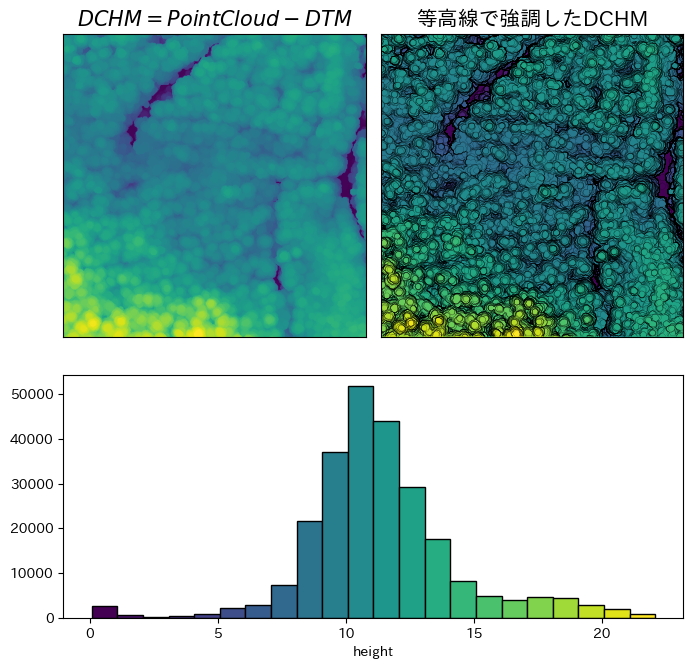

In [61]:
dchm_2 = crop_raster(dchm_dst, scope)

fig = plt.figure(figsize=(8, 8))
shape = (5, 2)
ax1 = plt.subplot2grid(shape=shape, loc=(0, 0), rowspan=3, colspan=1)
ax1.imshow(dchm_2, cmap='viridis')

ax2 = plt.subplot2grid(shape=shape, loc=(0, 1), rowspan=3, colspan=1)
ax2.imshow(dchm_2, cmap='viridis');
level = np.arange(dchm_1.min(), dchm_1.max(), 0.1)
ax2.contour(dchm_2, levels=level, linewidths=0.1, colors='black')

ax3 = plt.subplot2grid(shape=shape, loc=(3, 0), rowspan=2, colspan=2)
bins = np.arange(dchm_2.min(), dchm_2.max(), 1)
_, _, patches = ax3.hist(dchm_2.flatten(), ec='black', bins=bins)
ax3.set_xlabel('height')
jet = plt.get_cmap('viridis', len(patches))
for i, _ in enumerate(patches):
    patches[i].set_facecolor(jet(i))

titles = ['$DCHM = PointCloud - DTM$', '等高線で強調したDCHM']
for _ax, title in zip(fig.axes[: -1], titles):
    _ax.axes.yaxis.set_visible(False)
    _ax.axes.xaxis.set_visible(False)
    _ax.set_title(title, fontsize=15)

# plt.savefig(r'../images/session10/PointCloud_to_DCHM.png', dpi=350)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

<br>

### **2-3. 地上分解能の違うRasterでDCHMを計算する**
最後に地上分解能の違う DSM と DTM から DCHM を計算してみましょう。

DSM の分解能を変更してもいいのですが、今回は地理院の基盤地図情報ダウンロードサイトから入手したデータで作成した DTM を使用します。区別する為にこの DTM を DEM と呼ぶことにします。

In [15]:
dem_dst = rasterio.open(IN_FILE_PUB_DTM)
dem_meta = raster_metadata(dem_dst)
pprint(dem_meta)

{'area': 96849323.87071413,
 'bounds': BoundingBox(left=-10472.73044166876, bottom=36964.822112833644, right=-0.21449548612690705, top=46212.77402509757),
 'cells': 3154410,
 'data_type': ('float32',),
 'epsg': 6669,
 'height': 1669,
 'indexes': (1,),
 'nodata': -9999.0,
 'nodata_cells': 2296237,
 'nodata_ratio': 0.727945003978557,
 'polygon': 'POLYGON ((-0.214495 36964.822113, -0.214495 46212.774025, '
            '-10472.730442 46212.774025, -10472.730442 36964.822113, -0.214495 '
            '36964.822113))',
 'resolution': 5.541013728138959,
 'shape': (1669, 1890),
 'stats': Statistics(min=-1.2999999523163, max=534.81396484375, mean=122.3327783638, std=97.185356679184),
 'type': <class 'rasterio.io.DatasetReader'>,
 'width': 1890,
 'x_length': 9247.951912263925,
 'y_length': 10472.515946182633}


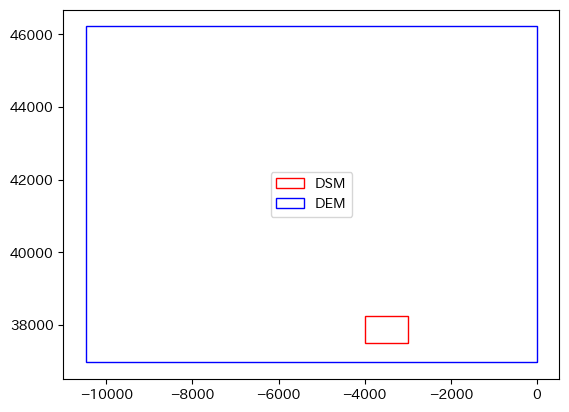

In [63]:
dsm_meta = raster_metadata(dsm_dst)

polys = [
    shapely.from_wkt(dsm_meta['polygon']), 
    shapely.from_wkt(dem_meta['polygon'])
]
labels = ['DSM', 'DEM']
colors = ['red', 'blue']

fig, ax = plt.subplots()
for poly, label, color in zip(polys, labels, colors):
    plot_polygon(poly, ax=ax, add_points=False, facecolor=(0,0,0,0),
                 edgecolor=color, label=label)
ax.legend()
# plt.savefig(r'../images/session10/scopes.png')
plt.show()

範囲も地上分解能も全然違う事が分かります。

分解能を合わせる為に DSM の分解能を取得して、DEM の各辺の長さを除算する事で新たな DEM 配列の形状を計算します。

分解能を上げる為にはアップサンプリングを行う必要がありますが、そういったモジュールがあるわけではなく、配列を読み込む時と同じ様に `read` メソッドでアップサンプリングを行います。

In [17]:
# DTMの分解能を取得して、各辺のセル数を求める。セル数は当然Int型なので注意
resolution = dsm_dst.meta['transform'][0]
x_cells = int(dem_meta['x_length'] / resolution)
y_cells = int(dem_meta['y_length'] / resolution)

# アップサンプリングした新たなDEMの配列を作成する。3次元で返されるので2次元にしておく。
upd_dem = dem_dst.read(
    # out_shape に新たな配列の形状を渡す。(counts, rows, cols)
    out_shape=(1, y_cells, x_cells),
    resampling=rasterio.enums.Resampling.bilinear
)[0]

print(f"""
Original shape: {dem_dst.read(1).shape}
UpSampling shape: {upd_dem.shape}
""")


Original shape: (1669, 1890)
UpSampling shape: (20945, 18495)



後から DSM と同じ範囲で切り抜きを行いたいので、Raster として保存する必要があります。'transform' にアップサンプリング後の情報を書き込み、インメモリに Raster を保存します

In [18]:
tf = dem_dst.transform
transform = tf * tf.scale(
    (dem_meta['width'] / upd_dem.shape[0]), 
    (dem_meta['height'] / upd_dem.shape[1])
)

meta = dsm_dst.meta
meta['width'] = upd_dem.shape[0]
meta['height'] = upd_dem.shape[1]
meta['transform'] = transform

upd_dem_dst = rasterio.MemoryFile().open(**meta)
upd_dem_dst.write(upd_dem, 1)

DSM のサンプルと同じ範囲で切り抜きを行います。

In [19]:
dem = crop_raster(upd_dem_dst, scope)

print(dem.shape)
print(dsm.shape)
print(dem)

(201, 201)
(200, 200)
[[-9999.         -9999.         -9999.         ... -9999.
  -9999.         -9999.        ]
 [  280.3576355    280.41085815   280.46405029 ...   296.21499634
    296.29244995 -9999.        ]
 [  280.5178833    280.57116699   280.62445068 ...   296.23498535
    296.31176758 -9999.        ]
 ...
 [  274.77178955   274.77124023   274.77072144 ...   297.23797607
    297.2749939  -9999.        ]
 [  275.19125366   275.18890381   275.18655396 ...   297.12771606
    297.16500854 -9999.        ]
 [  275.40097046   275.39770508   275.39447021 ...   297.07260132
    297.11001587 -9999.        ]]


配列形状が微妙に違いますが、一番上の行と、一番右側の列が -9999 になっているので取り除きます。

In [20]:
dem = dem[1: , : -1].copy()
print(f"""
DSM: {dsm.shape}
DEM: {dem.shape}
""")


DSM: (200, 200)
DEM: (200, 200)



配列の形状が整いました、あとは前と同じく計算するだけです。

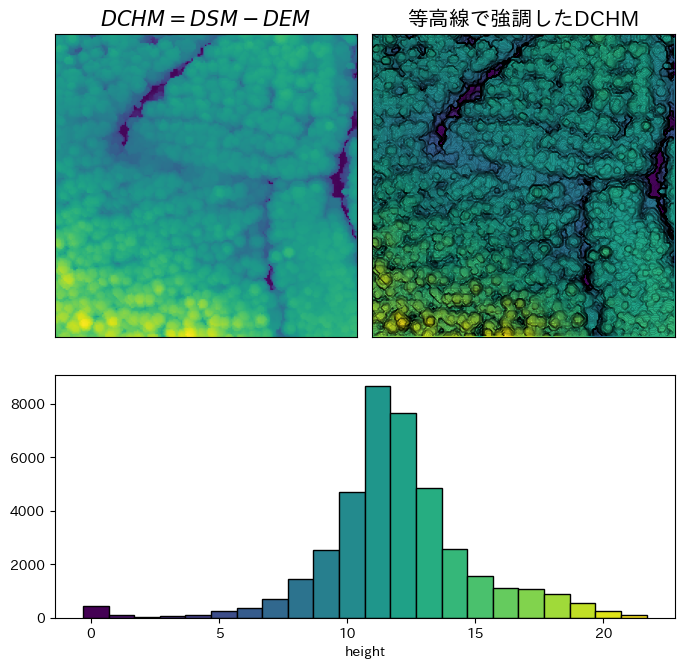

In [64]:
dchm_3 = dsm - dem

fig = plt.figure(figsize=(8, 8))
shape = (5, 2)
ax1 = plt.subplot2grid(shape=shape, loc=(0, 0), rowspan=3, colspan=1)
ax1.imshow(dchm_3, cmap='viridis')

ax2 = plt.subplot2grid(shape=shape, loc=(0, 1), rowspan=3, colspan=1)
ax2.imshow(dchm_3, cmap='viridis')
level = np.arange(dchm_3.min(), dchm_3.max(), 0.1)
ax2.contour(dchm_3, levels=level, linewidths=0.1, colors='black')

ax3 = plt.subplot2grid(shape=shape, loc=(3, 0), rowspan=2, colspan=2)
bins = np.arange(dchm_3.min(), dchm_3.max(), 1)
_, _, patches = ax3.hist(dchm_3.flatten(), ec='black', bins=bins)
ax3.set_xlabel('height')
jet = plt.get_cmap('viridis', len(patches))
for i, _ in enumerate(patches):
    patches[i].set_facecolor(jet(i))

titles = ['$DCHM = DSM - DEM$', '等高線で強調したDCHM']
for _ax, title in zip(fig.axes[: -1], titles):
    _ax.axes.yaxis.set_visible(False)
    _ax.axes.xaxis.set_visible(False)
    _ax.set_title(title, fontsize=15)

# plt.savefig(r'../images/session10/DEM_AND_DSM.png', dpi=350)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

最後に並べて比較してみましょう。

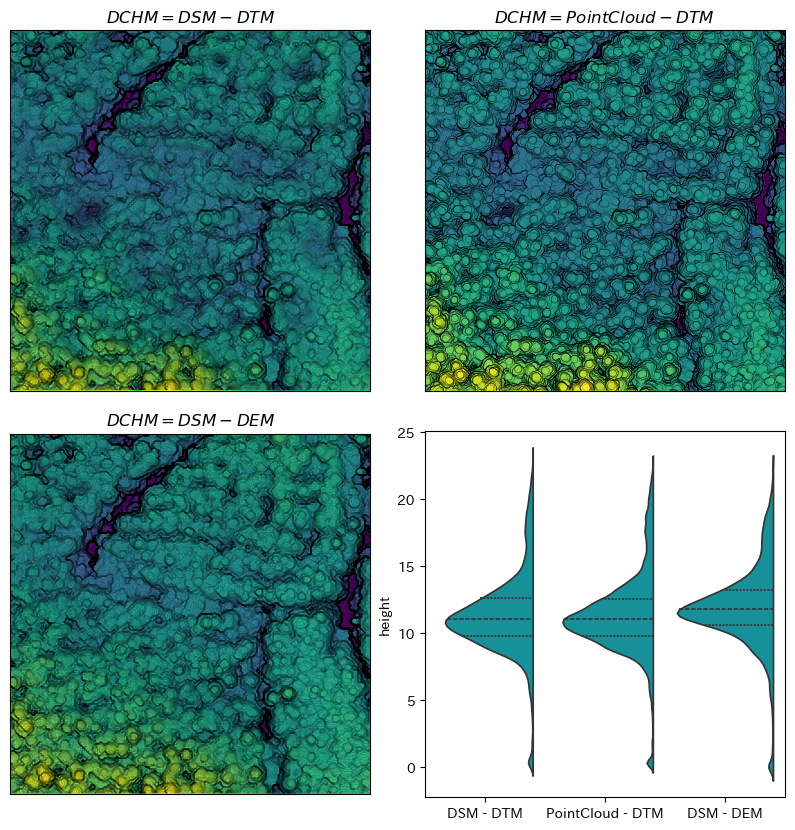

In [60]:
fig = plt.figure(figsize=(10, 10))
titles = [
    '$DCHM = DSM - DTM$',
    '$DCHM = PointCloud - DTM$',
    '$DCHM = DSM - DEM$'
]

# DCHM の可視化
for i, (title, img) in enumerate(zip(titles, [dchm_1, dchm_2, dchm_3])):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.imshow(img, cmap='viridis')
    level = np.arange(img.min(), img.max(), 0.1)
    ax.contour(img, levels=level, linewidths=0.1, colors='black')
    ax.set_title(title)
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)

# ヴァイオリンプロットで各DCHMの成分を可視化
values = np.concatenate([dchm_1.flatten(), dchm_2.flatten(), dchm_3.flatten()])
names = ['DSM - DTM' for _ in range(len(dchm_1.flatten()))] \
        + ['PointCloud - DTM' for _ in range(len(dchm_2.flatten()))] \
        + ['DSM - DEM' for _ in range(len(dchm_3.flatten()))]
ax4 = fig.add_subplot(2, 2, 4)
sns.violinplot(x=names, y=values, split=True, inner="quart", color='#00a3af', ax=ax4)
ax4.set_ylabel('height')
plt.subplots_adjust(wspace=0.15, hspace=0.1)
# plt.savefig(r'../images/session10/All_DCHMs.png', dpi=350)
plt.show()